# Customer churn

Customers began to leave Beta-Bank. Every month. A little, but noticeable. Banking marketers figured it was cheaper to keep current customers than to attract new ones.

It is necessary to predict whether the client will leave the bank in the near future or not. You are provided with historical data on customer behavior and termination of agreements with the bank.

Build a model with an extremely large *F1*-measure. To pass the project successfully, you need to bring the metric to 0.59. Check the *F1*-measure on the test set yourself.

Additionally measure *AUC-ROC*, compare its value with *F1*-measure.

Data source: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

<b>Features</b>
- `RowNumber` - row index in the data
- `CustomerId` - unique customer ID
- `Surname` - surname
- `CreditScore` - credit rating
- `Geography` - country of residence
- `Gender` - gender
- `Age` - age
- `Tenure` - how many years a person has been a client of the bank
- `Balance` - account balance
- `NumOfProducts` - the number of bank products used by the client
- `HasCrCard` - the presence of a credit card
- `IsActiveMember` - client activity
- `EstimatedSalary` - estimated salary

<b>Target feature</b>
- `Exited` — the fact that the client has left

## Data preparation

In [1]:
#import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings('ignore')

In [2]:
#look at the data in the dataset
df=pd.read_csv('/datasets/Churn.csv')
df.sample(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
1235,1236,15600700,Pan,523,Germany,Male,63,6.0,116227.27,1,1,1,119404.63,0
6596,6597,15654531,Tuan,477,France,Male,22,5.0,82559.42,2,0,0,163112.90,1
5748,5749,15678412,Nwankwo,645,France,Female,45,8.0,85325.93,1,0,0,22558.74,0
5622,5623,15766649,Vincent,670,France,Male,38,10.0,89416.99,1,0,0,144275.39,0
2674,2675,15756472,Odinakachukwu,804,France,Male,25,7.0,108396.67,1,1,0,128276.95,0
5501,5502,15796496,Trevisani,631,France,Female,31,8.0,137687.72,1,1,0,190067.12,0
9609,9610,15674833,Shao,741,France,Female,35,1.0,0.00,2,1,0,36557.55,0
5998,5999,15644212,Han,644,Spain,Male,28,0.0,0.00,2,1,0,119419.37,0
5870,5871,15780142,Wang,632,France,Male,43,2.0,100013.51,1,1,0,24275.32,0
4158,4159,15771580,Davison,850,France,Female,38,0.0,106831.69,1,0,1,148977.72,0


Since we need to predict the `Exited` column, which has only 0 or 1 values, we are faced with the task of classification.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


### Data preprocessing

The dataset has 14 columns and 10,000 rows. There are gaps only in the `Tenure` column.

Let's convert the column names to lower case.

In [4]:
df.columns = df.columns.str.lower()

In [5]:
#let's see what values are in the tenure column.
df['tenure'].value_counts()

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: tenure, dtype: int64

This column contains values from 0 to 10. this column contains information about the number of years spent by the client with the bank, let's replace gaps with medians depending on the age of the client.

In [6]:
df['tenure']= df['tenure'].fillna(df.groupby('age')['tenure'].transform('median')).astype('int32', errors= 'ignore')

In [7]:
#check the dataset for gaps
print('Number of duplicates:', df.duplicated().sum())

Number of duplicates: 0


Dataset columns `rownumber - row index in the data`, `customerid - unique client identifier` and `surname - client's last name` do not carry any useful information for the algorithm and can only confuse it with additional data, so they need to be removed from the dataset.

In [8]:
df = df.drop(['rownumber', 'customerid', 'surname'], axis = 1)

In [9]:
#check our final dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   creditscore      10000 non-null  int64  
 1   geography        10000 non-null  object 
 2   gender           10000 non-null  object 
 3   age              10000 non-null  int64  
 4   tenure           10000 non-null  int32  
 5   balance          10000 non-null  float64
 6   numofproducts    10000 non-null  int64  
 7   hascrcard        10000 non-null  int64  
 8   isactivemember   10000 non-null  int64  
 9   estimatedsalary  10000 non-null  float64
 10  exited           10000 non-null  int64  
dtypes: float64(2), int32(1), int64(6), object(2)
memory usage: 820.4+ KB


### Feature preparation

As you can see from the information about the dataset, the `geography` and `gender` columns have categorical features, so they need to be converted to numerical. Let's see what values are contained in these columns.

In [10]:
display(df['geography'].value_counts())
display(df['gender'].value_counts())

France     5014
Germany    2509
Spain      2477
Name: geography, dtype: int64

Male      5457
Female    4543
Name: gender, dtype: int64

There are 3 values in the `geography` column, and only 2 in the `gender` column. So we can convert these columns using the One-Hot Encoding (OHE) method.

In [11]:
df_ohe = pd.get_dummies(df, drop_first=True)

#look at the resulting dataset
df_ohe.sample(5)

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,geography_Germany,geography_Spain,gender_Male
4025,660,63,8,137841.53,1,1,1,42790.29,0,0,0,1
3670,850,28,4,0.00,2,1,1,12409.01,0,0,0,1
5479,569,35,3,116969.35,1,0,0,94488.82,0,0,1,1
3534,677,44,4,148770.61,2,1,1,191057.76,0,1,0,0
4674,850,41,1,176958.46,2,0,1,125806.30,0,1,0,1


The conversion of categorical data into numerical data was successful.

We select the features and the target feature, and then divide them into training, validation and test sets.

In [12]:
features = df_ohe.drop('exited', axis=1)
target = df_ohe['exited']

#select 20% from the dataset for the test sample
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=12345)

#and allocate another 20% of the remaining dataset to the validation sample
features_train, features_valid, target_train, target_valid = train_test_split(
    features_train, target_train, test_size=0.25, random_state=12345)

print('Training sample size:', len(target_train))
print('Test sample size:', len(target_test))
print('Validation sample size:', len(target_valid))

Training sample size: 6000
Test sample size: 2000
Validation sample size: 2000


Now let's scale the features using data standardization. To do this, we will use the Scaler method.

In [13]:
#First, select the columns to be scaled.
numeric=['creditscore', 'age', 'tenure', 'balance', 'numofproducts','estimatedsalary']

#now scale with Scaler
scaler = StandardScaler()
scaler.fit((features_train[numeric]))
features_train[numeric]=scaler.transform(features_train[numeric])
features_valid[numeric]=scaler.transform(features_valid[numeric])
features_test[numeric]=scaler.transform(features_test[numeric])

#check that the scaling was successful
print(features_train.sample(5))

      creditscore       age    tenure   balance  numofproducts  hascrcard  \
1128     0.237281 -0.650691 -0.006688  1.265405      -0.896909          1   
4453     1.619451 -0.555253  1.077812  1.143331      -0.896909          0   
889     -1.134574  0.399118 -0.006688  1.104219      -0.896909          0   
8590     1.227492  0.208244  1.800811  0.505536       4.244606          1   
2388     1.134660 -0.459816 -0.368188  0.192735       0.816929          1   

      isactivemember  estimatedsalary  geography_Germany  geography_Spain  \
1128               0        -0.039259                  0                0   
4453               0         1.727281                  1                0   
889                1        -1.558129                  0                0   
8590               1         0.654030                  0                0   
2388               0        -0.545441                  1                0   

      gender_Male  
1128            0  
4453            1  
889           

### Conclusion
1. Since we need to predict the `exited` column, which has only 0 or 1 values, we are faced with the task of classification.
2. The dataset has 14 columns and 10,000 rows. The gaps were only in the `tenure` column.
3. Gaps in the `tenure` column have been replaced with medians based on the client's age.
4. Dataset columns `rownumber - row index in the data`, `customerid - unique client identifier` and `surname - client`s surname` do not carry any useful information for the algorithm, therefore they were removed from the dataset.
5. The `geography` and `gender` columns have been converted from categorical to numerical.
6. In the dataset, features were scaled using data standardization.
7. Training, test and validation samples were selected from the dataset.

## Problem research

In this step, we will train the models without considering class imbalance. But first, let's look at the ratio of 0 and 1 in the `exited` column.

In [14]:
target.value_counts()

0    7963
1    2037
Name: exited, dtype: int64

The imbalance is large, the ratio is 80% to 20%. For clarity, let's look at the imbalance in the diagram.

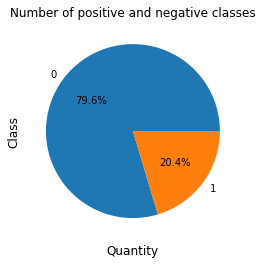

In [15]:
target.value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Number of positive and negative classes')
plt.xlabel('Quantity', fontsize=12)
plt.ylabel('Class', fontsize=12)
plt.show()

Let's train three models without taking into account the imbalance of classes.

### Decision tree

In [16]:
best_hp_f1 = [] #hp - is an abbreviation for hyperparameters
best_f1 = 0
best_hp_auc_roc = []
best_auc_roc = 0
best_tree = None
for depth in range(1, 20):
    for min_samples_leaf in range(1, 50):
        tree_model = DecisionTreeClassifier(random_state=12345, max_depth=depth, min_samples_leaf=min_samples_leaf)
        tree_model.fit(features_train, target_train)
        tree_predictions = tree_model.predict(features_valid)
        f1 = f1_score(target_valid, tree_predictions)
        probabilities_valid = tree_model.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]
        auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
        if f1 > best_f1:
            best_f1 = f1
            best_hp_f1 = [depth, min_samples_leaf]
            best_tree = tree_model
            best_auc_roc = auc_roc
            best_tree_depth = depth
            best_leaf = min_samples_leaf
            
            
print('Best f1 result for tree: {} с max_depth {} и min_samples_leaf {}'
      .format(best_f1, best_hp_f1[0], best_hp_f1[1]))
print('best auc_roc result for tree: {} с max_depth {} и min_samples_leaf {}'
      .format(best_auc_roc, best_hp_f1[0], best_hp_f1[1]))

Best f1 result for tree: 0.5828571428571429 с max_depth 10 и min_samples_leaf 38
best auc_roc result for tree: 0.8373940383297913 с max_depth 10 и min_samples_leaf 38


We got f1 equal to 0.58. Not bad, but it's less than 0.59.

We also found that the parameters f1 and AUC-ROC change synchronously when hyperparameters change: the higher f1 is, the higher the AUC-ROC.

Let's measure the area of the ROC curve to find out how much our model differs from the random one and what is the probability of a positive class.

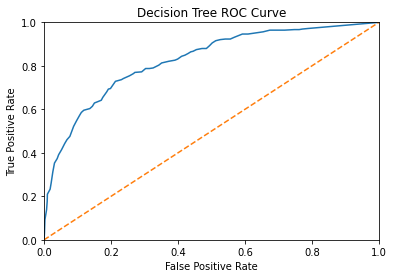

In [17]:
#look at the ROC-curve histogram
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree ROC Curve')
plt.show() 

Based on the histogram, the decision tree model works adequately and differs significantly from the random model.

### Random forest

In [18]:
best_hp_f1 = []
best_f1 = 0
best_hp_auc_roc = []
best_auc_roc = 0
best_forest = None
for depth in range(1, 15):
    for est in range(1, 50):
        forest_model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        forest_model.fit(features_train, target_train)
        forest_predictions = forest_model.predict(features_valid)
        f1 = f1_score(target_valid, forest_predictions)
        probabilities_valid = forest_model.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]
        auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
        if f1 > best_f1:
            best_f1 = f1
            best_hp_f1 = [depth, est]
            best_forest = forest_model
            best_auc_roc = auc_roc
            best_forest_depth = depth
            best_est = est

print('Best f1 result for forest: {} с max_depth {} и n_estimators {}'
      .format(best_f1, best_hp_f1[0], best_hp_f1[1]))
print('Best auc_roc result for tree: {} с max_depth {} и n_estimators {}'
      .format(best_auc_roc, best_hp_f1[0], best_hp_f1[1]))

Best f1 result for forest: 0.5705128205128206 с max_depth 11 и n_estimators 18
Best auc_roc result for tree: 0.8396424205913349 с max_depth 11 и n_estimators 18


We got f1 equal to 0.57. The result is worse than the decision tree.

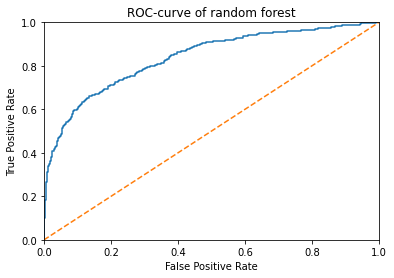

In [19]:
#and look at the histogram of the ROC curve
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0.0, 1.0], [0.0, 1.0], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve of random forest')
plt.show() 

Judging by the ROC curve, the model works adequately.

### Logistic regression

In [20]:
reg_model = LogisticRegression(random_state=12345, solver='liblinear')
reg_model.fit(features_train, target_train)
reg_predictions = reg_model.predict(features_valid)
f1 = f1_score(target_valid, reg_predictions)
probabilities_valid = reg_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print('F1 logistic regression:', f1)
print('AUC_ROC logistic regression:', auc_roc)

F1 logistic regression: 0.30131826741996237
AUC_ROC logistic regression: 0.7703296196744973


The f1 value is very low: only 0.3. This model is no good.

In [21]:
#measure the ROC curve
probabilities_valid = reg_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print(auc_roc)

0.7703296196744973


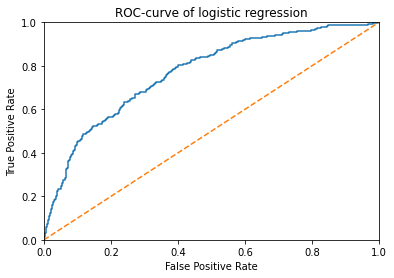

In [22]:
#and look at the histogram of the ROC curve
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0.0, 1.0], [0.0, 1.0], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve of logistic regression')
plt.show() 

This model turned out to be the weakest and does not greatly outperform random models.

### Conclusion

At this step, three models were trained without class imbalance.
1. According to the decision tree, we got f1 equal to 0.58. This is the highest result of the three models, but still not high enough to deliver our project to the customer.
2. Based on the random forest, we got f1 equal to 0.55. The result is worse than the decision tree.
3. Logistic regression in this situation turned out to be the weakest model and in its current state is no good.

## Fighting imbalance

To deal with imbalances, we use several methods:

1. Class weighting
2. Threshold change
3. Upsampling
4. Downsampling

### Class weighting

In [23]:
#check on the decision tree
tree_model_bal = DecisionTreeClassifier(random_state=12345,
                                        max_depth=best_tree_depth,
                                        min_samples_leaf=best_leaf,
                                        class_weight='balanced')
tree_model_bal.fit(features_train, target_train)
tree_bal_predictions = tree_model_bal.predict(features_valid)
f1_tree_bal = f1_score(target_valid, tree_bal_predictions)
probabilities_valid = tree_model_bal.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc_tree_bal = roc_auc_score(target_valid, probabilities_one_valid)

print('F1 of a decision tree with balanced classes is:', f1_tree_bal)
print('The AUC_ROC of a decision tree with balanced classes is:', auc_roc_tree_bal)

F1 of a decision tree with balanced classes is: 0.555765595463138
The AUC_ROC of a decision tree with balanced classes is: 0.8310168664433915


Previously, it was 0.58, and after weighing it became 0.55, i.e. the result deteriorated.

In [24]:
#random forest
forest_model_bal = RandomForestClassifier(random_state=12345,
                                          n_estimators=best_est,
                                          max_depth=best_forest_depth,
                                          class_weight='balanced')
forest_model_bal.fit(features_train, target_train)
forest_bal_predictions = forest_model_bal.predict(features_valid)
f1_forest_bal = f1_score(target_valid, forest_bal_predictions)
probabilities_valid = forest_model_bal.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc_forest_bal = roc_auc_score(target_valid, probabilities_one_valid)
print('F1 of a random forest with balanced classes is:', f1_forest_bal)
print('The AUC_ROC of a random forest with balanced classes is:', auc_roc_forest_bal)

F1 of a random forest with balanced classes is: 0.5607476635514018
The AUC_ROC of a random forest with balanced classes is: 0.8357520596262393


Random forest f1 decreased from 0.57 to 0.56.

In [25]:
#logistic regression
reg_model_bal = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
reg_model_bal.fit(features_train, target_train)
reg_bal_predictions = reg_model_bal.predict(features_valid)
f1_reg_bal = f1_score(target_valid, reg_bal_predictions)
probabilities_valid = reg_model_bal.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc_reg_bal = roc_auc_score(target_valid, probabilities_one_valid)
print('F1 of the logistic regression with balanced classes is', f1_reg_bal)
print('The AUC_ROC of the logistic regression with balanced classes is', auc_roc_reg_bal)

F1 of the logistic regression with balanced classes is 0.4741532976827095
The AUC_ROC of the logistic regression with balanced classes is 0.7725644909786543


According to the logistic regression, there was a significant increase in f1 and amounted to 0.47, but it is still very far from 0.59.

Class weighting almost did not give a significant increase in f1 and the difference is only noticeable in the logistic regression.

### Threshold change

In [26]:
#check how changing the threshold affects the decision tree
#check how changing the threshold affects the decision tree
best_threshold_tree = 0
best_f1_th_tree = 0
best_precision = 0
best_recall = 0
probabilities_valid = best_tree.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 1, 0.02):
    predicted_valid = probabilities_one_valid > threshold 
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    f1 = f1_score(target_valid, predicted_valid)
    if f1 > best_f1_th_tree:
        best_f1_th_tree = f1
        best_threshold_tree = threshold
        best_precision = precision
        best_recall = recall
print("Best threshold = {:.2f} | Precision = {:.3f}, Recall = {:.3f}, f1 = {:.2f}"
          .format(best_threshold_tree, best_precision, best_recall, best_f1_th_tree))

Best threshold = 0.46 | Precision = 0.656, Recall = 0.547, f1 = 0.60


<b>For the decision tree, f1 overcame the required threshold and reached the score of 0.6 with a threshold of 0.46.</b>

In [27]:
#check how changing the threshold affects the random forest
best_threshold_forest = 0
best_f1_th_forest = 0
best_precision = 0
best_recall = 0
probabilities_valid = best_forest.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 1, 0.02):
    predicted_valid = probabilities_one_valid > threshold 
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    f1 = f1_score(target_valid, predicted_valid)
    if f1 > best_f1_th_forest:
        best_f1_th_forest = f1
        best_threshold_forest = threshold
        best_precision = precision
        best_recall = recall
print("Best threshold = {:.2f} | Precision = {:.3f}, Recall = {:.3f}, f1 = {:.2f}"
          .format(best_threshold_forest, best_precision, best_recall, best_f1_th_forest))

Best threshold = 0.34 | Precision = 0.591, Recall = 0.573, f1 = 0.58


The best threshold is 0.34, but with it, the random forest did not reach the desired f1 value of 0.59.

In [28]:
#check how changing the threshold affects the logistic regression
best_threshold_reg = 0
best_f1_th_reg = 0
best_precision = 0
best_recall = 0
probabilities_valid = reg_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 1, 0.02):
    predicted_valid = probabilities_one_valid > threshold 
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    f1 = f1_score(target_valid, predicted_valid)
    if f1 > best_f1_th_reg:
        best_f1_th_reg = f1
        best_threshold_reg = threshold
        best_precision = precision
        best_recall = recall
print("Best threshold = {:.2f} | Precision = {:.3f}, Recall = {:.3f}, f1 = {:.2f}"
          .format(best_threshold_reg, best_precision, best_recall, best_f1_th_reg))

Best threshold = 0.32 | Precision = 0.500, Recall = 0.488, f1 = 0.49


According to the logistic regression, f1 increased to 0.49.

### Upsampling

To combat class imbalance, we will use the Upsampling technique and write a function for this.

In [29]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    #shuffle the data
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

In [30]:
target_upsampled.value_counts()

1    4876
0    4781
Name: exited, dtype: int64

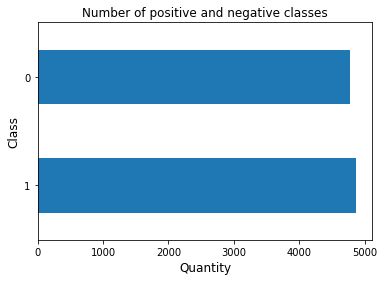

In [31]:
#look at the histogram for the ratio of classes
target_upsampled.value_counts().plot(kind='barh')
plt.title('Number of positive and negative classes')
plt.xlabel('Quantity', fontsize=12)
plt.ylabel('Class', fontsize=12)
plt.show()

Let's test our models on a larger sample.

#### Decision tree

In [32]:
best_hp_f1_up_tree = []
best_f1_up_tree = 0
best_hp_auc_roc_up_tree = []
best_auc_roc_up_tree = 0
best_tree_up = None
for depth in range(1, 20):
    for min_samples_leaf in range(1, 50):
        tree_model_up = DecisionTreeClassifier(random_state=12345, max_depth=depth, min_samples_leaf=min_samples_leaf)
        tree_model_up.fit(features_upsampled, target_upsampled)
        tree_predictions_up = tree_model_up.predict(features_valid)
        f1 = f1_score(target_valid, tree_predictions_up)
        probabilities_valid = tree_model_up.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]
        auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

        if f1 > best_f1_up_tree:
            best_f1_up_tree = f1
            best_hp_f1_up_tree = [depth, min_samples_leaf]
            best_tree_up = tree_model_up
            best_auc_roc_up_tree = auc_roc
           
print('Best f1 result for upsampled tree: {} с max_depth {} и min_samples_leaf {}'
      .format(best_f1_up_tree, best_hp_f1_up_tree[0], best_hp_f1_up_tree[1]))
print('Best auc_roc result for upsampled tree: {} с max_depth {} и min_samples_leaf {}'
      .format(best_auc_roc_up_tree, best_hp_f1_up_tree[0], best_hp_f1_up_tree[1]))

Best f1 result for upsampled tree: 0.5795918367346938 с max_depth 7 и min_samples_leaf 42
Best auc_roc result for upsampled tree: 0.8423557387394118 с max_depth 7 и min_samples_leaf 42


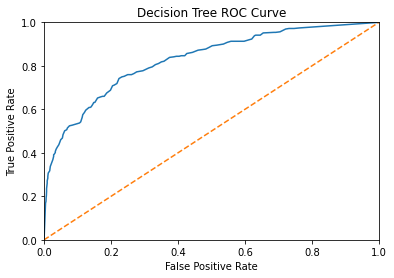

In [33]:
#and look at the histogram of the ROC curve
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree ROC Curve')
plt.show() 

With an increase in the sample, f1 of the decision tree became 0.57 instead of 0.58, and the AUC ROC remained at the same level, i.e. there were no positive changes.

#### Random forest

In [34]:
#test the increased sample on a random forest
best_hp_f1_up_forest = []
best_f1_up_forest = 0
best_hp_auc_roc_up_forest = []
best_auc_roc_up_forest = 0
best_forest_up = None
for depth in range(1, 15):
    for est in range(1, 50):
        forest_model_up = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        forest_model_up.fit(features_upsampled, target_upsampled)
        forest_predictions_up = forest_model_up.predict(features_valid)
        f1 = f1_score(target_valid, forest_predictions_up)
        probabilities_valid = forest_model_up.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]
        auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
        if f1 > best_f1_up_forest:
            best_f1_up_forest = f1
            best_hp_f1_up_forest = [depth, est]
            best_forest_up = forest_model_up
            best_auc_roc_up_forest = auc_roc
            
print('The best f1 result for the forest on the increased sample: {} с max_depth {} и n_estimators {}'
      .format(best_f1_up_forest, best_hp_f1_up_forest[0], best_hp_f1_up_forest[1]))
print('The best auc_roc result for a tree on a larger sample: {} с max_depth {} и n_estimators {}'
      .format(best_auc_roc_up_forest, best_hp_f1_up_forest[0], best_hp_f1_up_forest[1]))

The best f1 result for the forest on the increased sample: 0.5997521685254027 с max_depth 13 и n_estimators 41
The best auc_roc result for a tree on a larger sample: 0.8447368462882222 с max_depth 13 и n_estimators 41


<b>On the enlarged sample, the f1 indicator of 0.59 was achieved.</b>

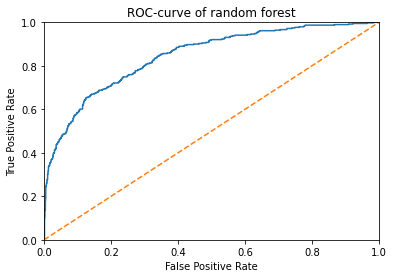

In [35]:
#and look at the histogram of the ROC curve
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0.0, 1.0], [0.0, 1.0], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve of random forest')
plt.show() 

#### Logistic regression

In [36]:
reg_model_up = LogisticRegression(random_state=12345, solver='liblinear')
reg_model_up.fit(features_upsampled, target_upsampled)
reg_up_predictions = reg_model_up.predict(features_valid)
f1_reg_up = f1_score(target_valid, reg_up_predictions)
probabilities_valid = reg_model_up.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc_reg_up = roc_auc_score(target_valid, probabilities_one_valid)

print('F1 logistic regression on a larger sample:', f1_reg_up)
print('AUC_ROC logistic regression on a larger sample:', auc_roc_reg_up)

F1 logistic regression on a larger sample: 0.4771126760563381
AUC_ROC logistic regression on a larger sample: 0.7725597224054591


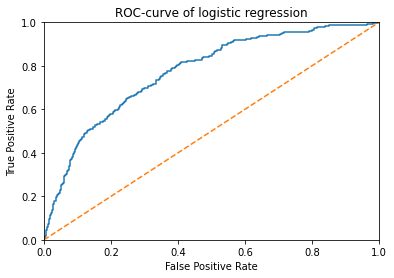

In [37]:
#and look at the histogram of the ROC curve
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0.0, 1.0], [0.0, 1.0], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve of logistic regression')
plt.show() 

With the help of upsampling, the required f1 indicator was achieved only on a random forest. The other two models did not show an increase in f1.

### Downsampling

Using the downsampling technique, we randomly discard some of the negative objects to reduce the sample.

In [38]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

In [39]:
#check the number of resulting objects
target_downsampled.value_counts()

1    1219
0    1195
Name: exited, dtype: int64

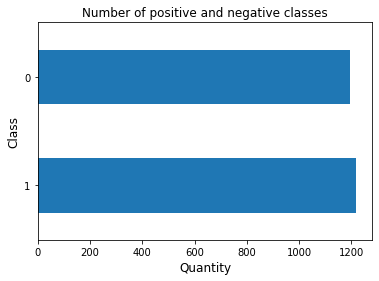

In [40]:
target_downsampled.value_counts().plot(kind='barh')
plt.title('Number of positive and negative classes')
plt.xlabel('Quantity', fontsize=12)
plt.ylabel('Class', fontsize=12)
plt.show()

Class balance achieved. Let's test the reduced sample on our models.

#### Decision tree

In [41]:
#check the reduced sample on the decision tree
best_hp_f1_down_tree = []
best_f1_down_tree = 0
best_hp_auc_roc_down_tree = []
best_auc_roc_down_tree = 0
best_tree_down = None
for depth in range(1, 20):
    for min_samples_leaf in range(1, 50):
        tree_model_down = DecisionTreeClassifier(random_state=12345, max_depth=depth, min_samples_leaf=min_samples_leaf)
        tree_model_down.fit(features_downsampled, target_downsampled)
        tree_predictions_down = tree_model_down.predict(features_valid)
        f1 = f1_score(target_valid, tree_predictions_down)
        probabilities_valid = tree_model_down.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]
        auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
        if f1 > best_f1_down_tree:
            best_f1_down_tree = f1
            best_hp_f1_down_tree = [depth, min_samples_leaf]
            best_tree_down = tree_model_down
            best_auc_roc_down_tree = auc_roc
            
print('Best f1 result for downsampled tree: {} с max_depth {} и min_samples_leaf {}'
      .format(best_f1_down_tree, best_hp_f1_down_tree[0], best_hp_f1_down_tree[1]))
print('Best auc_roc result for downsampled tree: {} с max_depth {} и min_samples_leaf {}'
      .format(best_auc_roc_down_tree, best_hp_f1_down_tree[0], best_hp_f1_down_tree[1]))

Best f1 result for downsampled tree: 0.5533522190745986 с max_depth 6 и min_samples_leaf 14
Best auc_roc result for downsampled tree: 0.8145350879563326 с max_depth 6 и min_samples_leaf 14


The result worsened compared to the increased sample and f1 is 0.55.

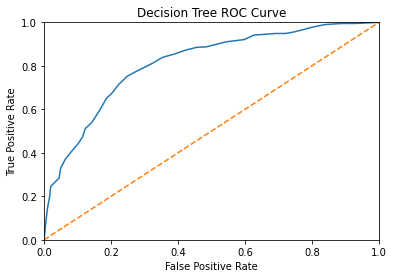

In [42]:
#and look at the histogram of the ROC curve
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree ROC Curve')
plt.show() 

#### Random forest

In [43]:
#check the reduced sample on a random forest
#test the increased sample on a random forest
best_hp_f1_down_forest = []
best_f1_down_forest = 0
best_hp_auc_roc_down_forest = []
best_auc_roc_down_forest = 0
best_forest_down = None
for depth in range(1, 15):
    for est in range(1, 50):
        forest_model_down = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        forest_model_down.fit(features_downsampled, target_downsampled)
        forest_predictions_down = forest_model_down.predict(features_valid)
        f1 = f1_score(target_valid, forest_predictions_down)
        probabilities_valid = forest_model_down.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]
        auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
        if f1 > best_f1_down_forest:
            best_f1_down_forest = f1
            best_hp_f1_down_forest = [depth, est]
            best_forest_down = forest_model_down
            best_auc_roc_down_forest = auc_roc
            
print('The best f1 result for the forest on a reduced sample: {} с max_depth {} и n_estimators {}'
      .format(best_f1_down_forest, best_hp_f1_down_forest[0], best_hp_f1_down_forest[1]))
print('Best auc_roc result for downsampled tree: {} с max_depth {} и n_estimators {}'
      .format(best_auc_roc_down_forest, best_hp_f1_down_forest[0], best_hp_f1_down_forest[1]))

The best f1 result for the forest on a reduced sample: 0.5694980694980695 с max_depth 9 и n_estimators 9
Best auc_roc result for downsampled tree: 0.8355032990578889 с max_depth 9 и n_estimators 9


The quality of the model has decreased compared to upsampling.

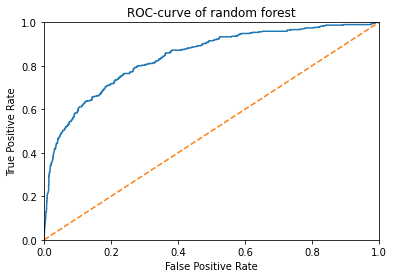

In [44]:
#and look at the histogram of the ROC curve
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0.0, 1.0], [0.0, 1.0], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve of random forest')
plt.show() 

#### Logistic regression

In [45]:
reg_model_down = LogisticRegression(random_state=12345, solver='liblinear')
reg_model_down.fit(features_downsampled, target_downsampled)
reg_down_predictions = reg_model_down.predict(features_valid)
f1_reg_down = f1_score(target_valid, reg_down_predictions)
probabilities_valid = reg_model_down.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc_reg_down = roc_auc_score(target_valid, probabilities_one_valid)

print('F1 Logistic Regression on a Reduced Sample:', f1_reg_down)
print('AUC_ROC of a downsampled logistic regression:', auc_roc_reg_down)

F1 Logistic Regression on a Reduced Sample: 0.47493403693931396
AUC_ROC of a downsampled logistic regression: 0.7737709399970436


Logistic regression shows the same result as when balancing classes or increasing the sample.

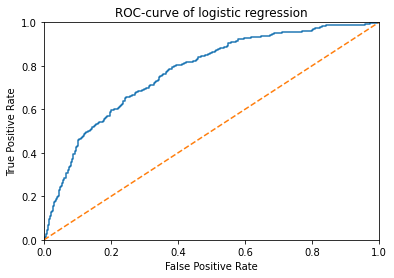

In [46]:
#and look at the histogram of the ROC curve
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0.0, 1.0], [0.0, 1.0], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve of logistic regression')
plt.show() 

As a result of the reduction in the sample, the quality of the decision tree and random forest deteriorated, while the quality of the work of the logistic regression remained at the same level and did not change.

### Conclusion

1. Several methods have been used to combat the imbalance:
- Class weighting
- Threshold change
- Upsampling
- Downsampling.
2. Changing the decision tree threshold to 0.46 increased f1 to 0.6 and made it possible to overcome the required threshold.
3. Using the upsampling method on the validation set, the threshold value f1 for the random forest was reached.
4. f1 for logistic regression reaches a maximum of 0.49 using all these methods.

In [47]:
#class weighting summary table
pivot_balanced = pd.DataFrame({'ML-модель': ['Decision Tree', 'Random Forest', 'Logistic Regression'],
        'F1_balanced': [f1_tree_bal, f1_forest_bal, f1_reg_bal],
        'AUC-ROC_balanced': [auc_roc_tree_bal, auc_roc_forest_bal, auc_roc_reg_bal]})
pivot_balanced

,ML-модель,F1_balanced,AUC-ROC_balanced
0,Decision Tree,0.555766,0.831017
1,Random Forest,0.560748,0.835752
2,Logistic Regression,0.474153,0.772564


In [48]:
#pivot table to change the threshold
pivot_threshold = pd.DataFrame({'ML-модель': ['Decision Tree', 'Random Forest', 'Logistic Regression'],
        'Best f1': [best_f1_th_tree, best_f1_th_forest, best_f1_th_reg],
        'Best threshold': [best_threshold_tree, best_threshold_forest, best_threshold_reg]})
pivot_threshold

,ML-модель,Best f1,Best threshold
0,Decision Tree,0.596932,0.46
1,Random Forest,0.581818,0.34
2,Logistic Regression,0.494179,0.32


In [49]:
#pivot table for increased selection
pivot_upsampling = pd.DataFrame({'ML-модель': ['Decision Tree', 'Random Forest', 'Logistic Regression'],
        'F1_upsampled': [best_f1_up_tree, best_f1_up_forest, f1_reg_up],
        'AUC-ROC_upsampled': [best_auc_roc_up_tree, best_auc_roc_up_forest, auc_roc_reg_up],
        'Best params for f1 (depth, leaf/est)':[best_hp_f1_up_tree, best_hp_f1_up_forest, 'No']})
        
pivot_upsampling

,ML-модель,F1_upsampled,AUC-ROC_upsampled,"Best params for f1 (depth, leaf/est)"
0,Decision Tree,0.579592,0.842356,"[7, 42]"
1,Random Forest,0.599752,0.844737,"[13, 41]"
2,Logistic Regression,0.477113,0.772560,No


In [50]:
#pivot table for reduced sample
pivot_downsampling = pd.DataFrame({'ML-модель': ['Decision Tree', 'Random Forest', 'Logistic Regression'],
        'F1_downsampled': [best_f1_down_tree, best_f1_down_forest, f1_reg_down],
        'AUC-ROC_downsampled': [best_auc_roc_down_tree, best_auc_roc_down_forest, auc_roc_reg_down],
        'Best params for f1 (depth, leaf/est)':[best_hp_f1_down_tree, best_hp_f1_down_forest, 'No']})
pivot_downsampling

,ML-модель,F1_downsampled,AUC-ROC_downsampled,"Best params for f1 (depth, leaf/est)"
0,Decision Tree,0.553352,0.814535,"[6, 14]"
1,Random Forest,0.569498,0.835503,"[9, 9]"
2,Logistic Regression,0.474934,0.773771,No


## Model testing

For the test sample, we will use models that showed the best result when increasing the sample using the `upsampling` method.

### Decision Tree

In [51]:
final_tree = best_tree_up
                                    
final_tree_predictions = final_tree.predict(features_test)
probabilities_test = final_tree.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_one_test)

print('f1 of the final decision tree is:', f1_score(target_test, final_tree_predictions))
print('AUC-ROC of the final decision tree is:', auc_roc)

f1 of the final decision tree is: 0.6058879392212726
AUC-ROC of the final decision tree is: 0.8462260541247129


Great, the decision tree has passed the minimum threshold of 0.59.

AUC-ROC also increased by one point compared to the previous trained tree models.

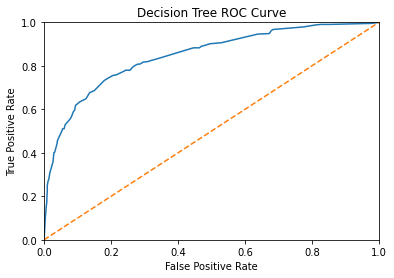

In [52]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree ROC Curve')
plt.show() 

The decision tree coped with the task. Let's check the remaining models.

### Random forest

In [53]:
final_forest = best_forest_up
                                                                                                              
final_forest_predictions = final_forest.predict(features_test)
probabilities_test = final_forest.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_one_test)

print('f1 of the final random forest is:', f1_score(target_test, final_forest_predictions))
print('The AUC-ROC of the final random forest is:', auc_roc)

f1 of the final random forest is: 0.6263345195729537
The AUC-ROC of the final random forest is: 0.8543394012842598


F1 of the random forest is 0.62 and exceeds the predictions on the validation set.

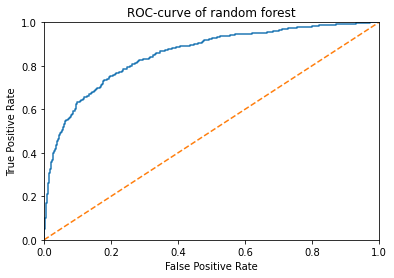

In [54]:
#and look at the histogram of the ROC curve
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0.0, 1.0], [0.0, 1.0], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve of random forest')
plt.show() 

Random forest achieved a very good performance both in the quality of predictions and in AUC-ROC.

### Logistic regression

In [55]:
final_regression = reg_model_up

final_regression_predictions = final_regression.predict(features_test)
probabilities_test = final_regression.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_one_test)

print('F1 final logistic regression:', f1_score(target_test, final_regression_predictions))
print('AUC-ROC of the final logistic regression:', auc_roc)

F1 final logistic regression: 0.504983388704319
AUC-ROC of the final logistic regression: 0.7638248487726879


The logistic regression turned out to be very far from the required result, so this model is not suitable for solving the problem.

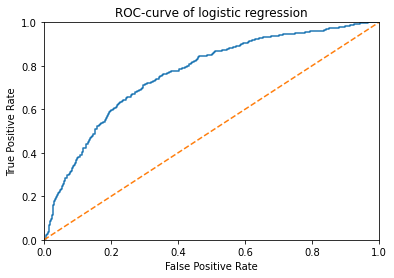

In [56]:
#and look at the histogram of the ROC curve
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0.0, 1.0], [0.0, 1.0], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve of logistic regression')
plt.show() 

### Conclusion

1. The decision tree showed a good result f1 - 0.605.
2. The random forest showed the best result f1 among all the models used - 0.626, this model will be used in solving the tasks.
3. Logistic regression is again outsiders and has not reached the f1 threshold of 0.59, so this model is not suitable for us.

## Conclusion on the project

1. Since we need to predict the `exited` column, which only has the values ​​0 or 1, we were faced with the task of binary classification.
2. Data preprocessing was carried out:
    1. Gaps in the `tenure` column have been replaced with medians based on the client's age.
    2. Dataset columns `rownumber - row index in the data`, `customerid - unique client identifier` and `surname - client's surname` did not carry any useful information for the algorithm, so they were removed from the dataset.
    3. The `geography` and `gender` columns have been converted from categorical to numerical.
    4. In the dataset, features were scaled using data standardization.
    5. Training, test and validation samples were selected from the dataset.
3. Three models were trained without class imbalance:
    1. According to the decision tree, we got f1 equal to 0.58. It was the highest result of the three models, but still not high enough to deliver our project to the customer.
    2. Based on the random forest, we got f1 equal to 0.55. The result turned out to be worse than that of the decision tree.
    3. Logistic regression in this situation turned out to be the weakest model with f1 equal to 0.3.
4. Several methods have been used to deal with imbalances:
    - Class weighting
    - Threshold change
    - Upsampling
    - Downsampling.
    1. Changing the decision tree threshold to 0.46 increased f1 to 0.6 and made it possible to overcome the required threshold.
    2. Using the upsampling method on the validation set, the threshold value f1 of 0.59 was reached for the random forest.
    3. f1 for logistic regression reached a maximum of 0.48 using all of the above methods.
5. When checking on a test sample:
    1. The decision tree showed a good result f1 - 0.605.
    2. <b>The random forest showed the best result f1 among all the used models - 0.626, this model will be used in solving the tasks.</b>
    3. The logistic regression did not reach the threshold value f1 of 0.59, so this model is not suitable for us in solving the problem.